In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Colab \Notebooks/microscopy_self_supervised_learning/

/content/drive/MyDrive/Colab Notebooks/microscopy_self_supervised_learning


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm

sns.set(style="whitegrid")

In [5]:
metadata = pd.read_csv("data/processed/metadata_with_moa.csv")
metadata.head(3)

,Unnamed: 0,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,plate,well,Replicate,compound,concentration,moa
0,0,1,11,Week1_150607_B04_s3_w135D66B4C-0548-4AB8-A57B-...,Week1/Week1_22123,Week1_150607_B04_s3_w2D81AEFB9-9DD4-4B59-9177-...,Week1/Week1_22123,Week1_150607_B04_s3_w408BE006A-BF34-457E-81A9-...,Week1/Week1_22123,Week1_22123,B04,1,cytochalasin B,10.0,Actin disruptors
1,1,1,12,Week1_150607_B04_s4_w1EB720AD1-83BA-48A7-8C47-...,Week1/Week1_22123,Week1_150607_B04_s4_w261B79A05-7534-46F3-8C80-...,Week1/Week1_22123,Week1_150607_B04_s4_w49FF7E7B1-F049-4994-BCA2-...,Week1/Week1_22123,Week1_22123,B04,1,cytochalasin B,10.0,Actin disruptors
2,2,1,9,Week1_150607_B04_s1_w11323931B-BDA7-4F42-870E-...,Week1/Week1_22123,Week1_150607_B04_s1_w2F8F7EA7A-EC57-49CA-A556-...,Week1/Week1_22123,Week1_150607_B04_s1_w494DCA5C4-3531-497D-A8B0-...,Week1/Week1_22123,Week1_22123,B04,1,cytochalasin B,10.0,Actin disruptors


In [6]:
import os
import tifffile as tiff
import numpy as np

BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/microscopy_self_supervised_learning/data/raw"

def fix_path(pathname):
    return pathname.split("/")[-1]

def load_3channel_image(row):
    paths = [
        os.path.join(BASE_DIR, fix_path(row["Image_PathName_DAPI"]), row["Image_FileName_DAPI"]),
        os.path.join(BASE_DIR, fix_path(row["Image_PathName_Tubulin"]), row["Image_FileName_Tubulin"]),
        os.path.join(BASE_DIR, fix_path(row["Image_PathName_Actin"]), row["Image_FileName_Actin"])
    ]

    channels = []
    for p in paths:
        img = tiff.imread(p)
        channels.append(img)

    img_stack = np.stack(channels, axis=0)  # (3, H, W)
    return img_stack

system is crashng, creating samples

In [7]:
subset = metadata.sample(n=300, random_state=42)

In [8]:
from skimage.transform import resize

X = []
y = []

for _, row in tqdm(subset.iterrows(), total=len(subset)):
    img = load_3channel_image(row)   # (3,H,W)

    img_small = resize(img, (3,128,128), anti_aliasing=True)
    X.append(img_small.flatten())
    y.append(row["moa"])

X = np.array(X)
print("X shape:", X.shape)

100%|██████████| 300/300 [01:51<00:00,  2.69it/s]

X shape: (300, 49152)


In [6]:
# # load images
# X = []
# y = []

# for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
#     img = load_3channel_image(row)  # (3,H,W)
#     X.append(img.flatten())
#     y.append(row["moa"])

100%|██████████| 300/300 [00:32<00:00,  9.21it/s]


In [9]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

print(X.shape)

(300, 49152)


In [12]:
# PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

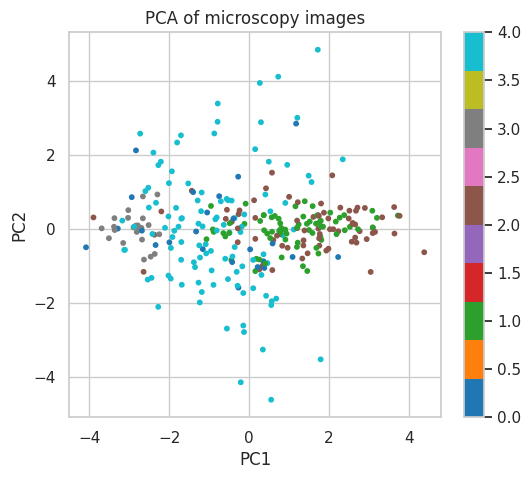

In [13]:
# Plot first 2 PCs
plt.figure(figsize=(6,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_enc, cmap="tab10", s=10)
plt.title("PCA of microscopy images")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(scatter)
plt.show()